# Packages

In [3]:
#%% packages
import numpy as np
import scipy
import pandas as pd
import pprint
import joblib
from functools import partial

import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBRegressor, DMatrix

# Model selection
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

import sys
import os
from pathlib import Path
import pickle as pkl

# import another script
# import function_train_xgb as ftx

# import all
from function_train_xgb import *

all the functions to train xgb loaded!


# Working directory

In [4]:
project_dir = Path("working_directory")
project_dir.mkdir(exist_ok=True)
site = "BART_AmeriFlux"
site_data_dir = project_dir / site
site_data_dir.mkdir(exist_ok=True)
save_dir = site_data_dir / "XGB_models"
save_dir.mkdir(exist_ok=True)
data_train_test_dir = site_data_dir / "data_train_test"
sys.path.append(site_data_dir)
os.chdir(site_data_dir)
cwd = os.getcwd()

# Input features and targest variable

In [9]:
predictor_subsets = {
        "GCC+Base": ['TIMESTAMP_END', 'GCC', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos']
}   

# Search space

In [11]:
from skopt.space import Real, Integer
search_spaces = {'learning_rate': Real(0.00001, 0.3, 'uniform'), 
                 'max_depth': Integer(3,7),
                 'subsample': Real(0.6, 0.8, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), 
                 'reg_lambda': Real(1e-9, 10., 'uniform'), 
                 'reg_alpha': Real(1e-9, 10., 'uniform'), 
                 'n_estimators': Integer(20, 2000)
}

# Load site data 

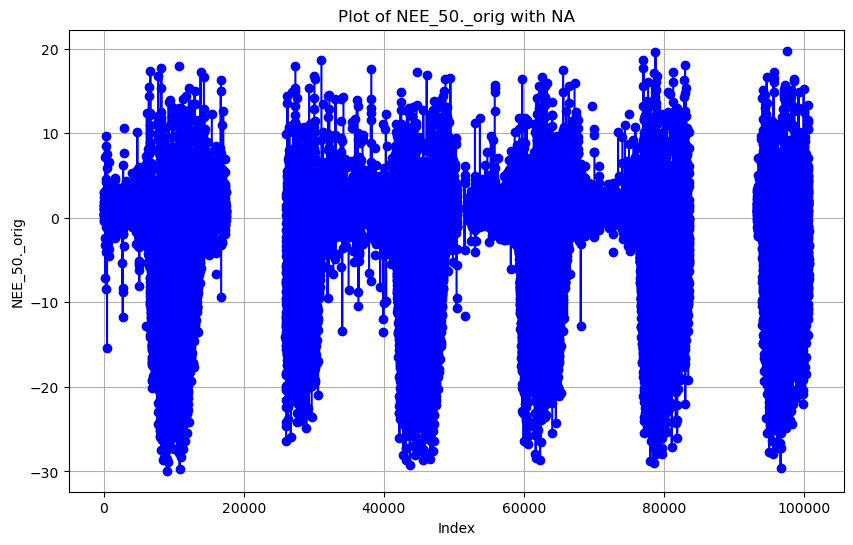

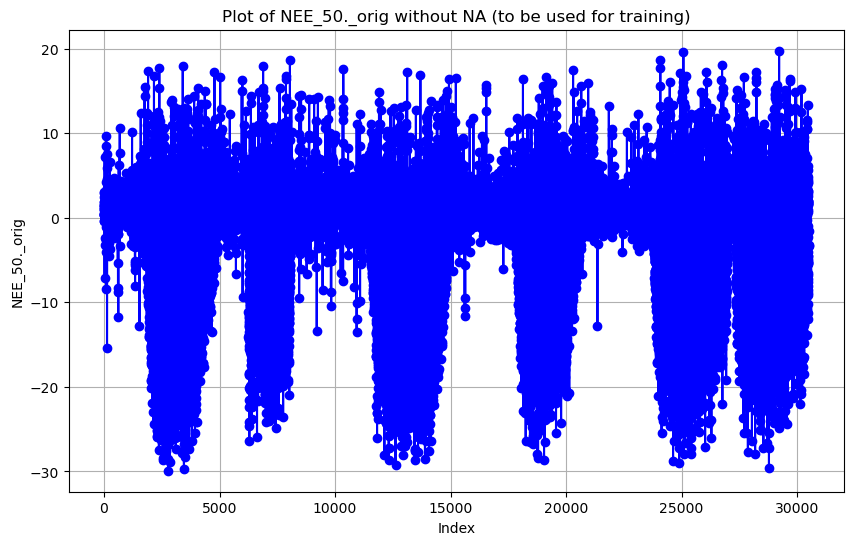

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set the working directory
output_dir = Path("working_directory/BART_AmeriFlux/")
os.chdir(output_dir)

# Read the data from the CSV file
site_data = pd.read_csv("data_for_XGB_BART_AmeriFlux.csv")

# Define the column to be plotted
y_col = 'NEE_50._orig'

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(site_data[y_col].values, marker='o', linestyle='-', color='b')
plt.title(f'Plot of {y_col} with NA')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()

# Drop rows with missing values in the specified column
site_data = site_data.dropna(subset=[y_col]) # use this dataset to find the best hyperparameter

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(site_data[y_col].values, marker='o', linestyle='-', color='b')
plt.title(f'Plot of {y_col} without NA (to be used for training)')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()


# Step 1: find the best hyperparameters

In [9]:
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

y = site_data[y_col] # target variable

for subset_name, subset_features in predictor_subsets.items():
    model_dir = save_dir / subset_name
    model_dir.mkdir(exist_ok=True, parents=True)

    X = site_data[subset_features] # input features

    # Setting the scoring function
    scoring = make_scorer(partial(mean_squared_error, squared=False), greater_is_better=False)
    
    # 10-fold cv
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_strategy = list(cv.split(X, y))

    # Set up basic regressor: random_state affects sampling data (selecting of the rows), hist
    reg = XGBRegressor(random_state=42, booster='gbtree', objective='reg:squarederror', tree_method='hist')

    # Wrapping everything up into the Bayesian optimizer
    opt = BayesSearchCV(estimator=reg,
                        search_spaces=search_spaces,
                        scoring=scoring,
                        cv=cv_strategy,
                        n_iter=5100,  # max number of trials
                        n_points=20,  # number of hyperparameter sets evaluated at the same time
                        n_jobs=50,  # -1 to use all the available cores
                        iid=False,  # if not iid it optimizes on the cv score
                        return_train_score=False,
                        refit=False,
                        optimizer_kwargs={'base_estimator': 'GP'},  # optimizer parameters: we use Gaussian Process (GP)
                        random_state=42)

    # Running the optimizer
    print('Start to run the optimizer ...')
    overdone_control = DeltaYStopper(delta=0.0001)  # We stop if the gain of the optimization becomes too small
    time_limit_control = DeadlineStopper(total_time=60*60*0.2)  # We impose a time limit (1 hour)

    best_params = report_perf(opt, X, y, 'XGBoost_regression', callbacks=[overdone_control, time_limit_control])
    print(f"Running: best_params={best_params}")

    # Save hyperparameters as CSV
    csv_file = model_dir / 'model_best_params.csv'

    # Write dictionary data to CSV file
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['parameter', 'value'])  # Write header
        for param, value in best_params.items():
            writer.writerow([param, value])
    print(f'Data has been written to {csv_file}')

    # Transferring the best parameters to our basic regressor
    reg = XGBRegressor(random_state=42, booster='gbtree', objective='reg:squarederror', tree_method='hist',
                       **best_params, n_jobs=50)

    # Save model object as pkl
    model_path = model_dir / "model.pkl"
    with open(model_path, 'wb') as f:
        pkl.dump(reg, f)
    print(f"Model pkl files saved to {model_path}.")

Start to run the optimizer ...


XGBoost_regression took 529.21 seconds,  candidates checked: 80, best CV score: -2.610 ± 0.066
Best parameters:
OrderedDict([('colsample_bytree', 0.9983422819350287), ('learning_rate', 0.020446024638744845), ('max_depth', 6), ('n_estimators', 1780), ('reg_alpha', 8.804319166187309), ('reg_lambda', 0.8918061853490781), ('subsample', 0.7828909488697074)])
Running: best_params=OrderedDict([('colsample_bytree', 0.9983422819350287), ('learning_rate', 0.020446024638744845), ('max_depth', 6), ('n_estimators', 1780), ('reg_alpha', 8.804319166187309), ('reg_lambda', 0.8918061853490781), ('subsample', 0.7828909488697074)])
Data has been written to E:\13 Gapfill_since_2017\BART_AmeriFlux\XGB_models\03_GCC+Base\model_best_params.csv
Model pkl files saved to E:\13 Gapfill_since_2017\BART_AmeriFlux\XGB_models\03_GCC+Base\model.pkl.


# Step 2: fit/train the model (10 fold CV)

## accurate prediction using all data

In [10]:
import pickle as pickle
site_data = pd.read_csv(site_data_dir / "data_for_XGB_BART_AmeriFlux.csv", index_col=0) # .dropna(subset=[y_col])
site_data_no_na = pd.read_csv(site_data_dir / "data_for_XGB_BART_AmeriFlux.csv", index_col=0).dropna(subset=[y_col])
site_data =  add_time_vars(site_data)
site_data_no_na =  add_time_vars(site_data_no_na)

for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir / subset_name) / "model.pkl"
    print(model_path)
    with open(model_path, 'rb') as f:
        reg = pickle.load(f)
    print(reg)

    X = site_data_no_na[subset_features]
    y = site_data_no_na[y_col] 
    reg.fit(X, y)

    X_all = site_data[subset_features]
    y_pred = reg.predict(X_all)
    site_data['XGB_NEE_U50_fall'] = y_pred 
    site_data['XGB_NEE_U50_f'] = np.where(site_data[y_col].notnull(), site_data[y_col], site_data['XGB_NEE_U50_fall'])
    site_data.to_csv(all_prediction_dir / (subset_name + '_all_prediction.csv'))

03_GCC+Base
E:\13 Gapfill_since_2017\BART_AmeriFlux\XGB_models\03_GCC+Base\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9983422819350287, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.020446024638744845,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1780, n_jobs=50, num_parallel_tree=None,
             predictor=None, random_state=42, ...)


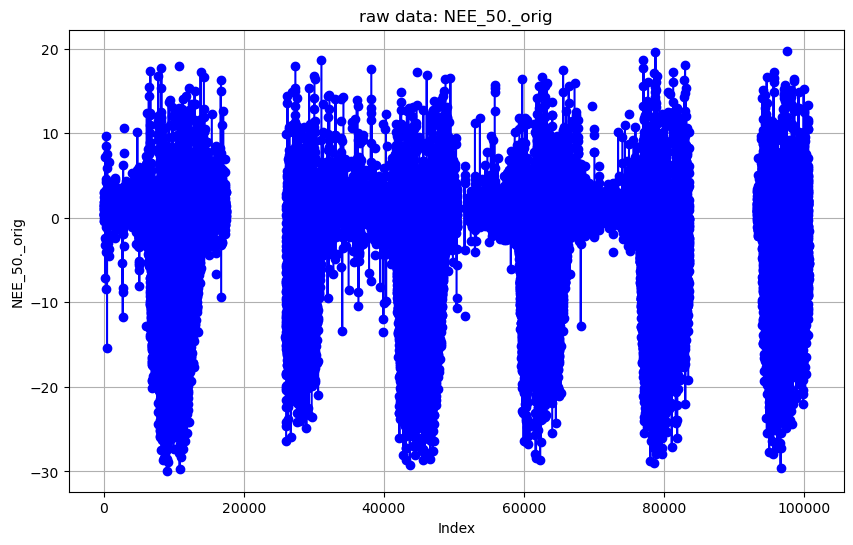

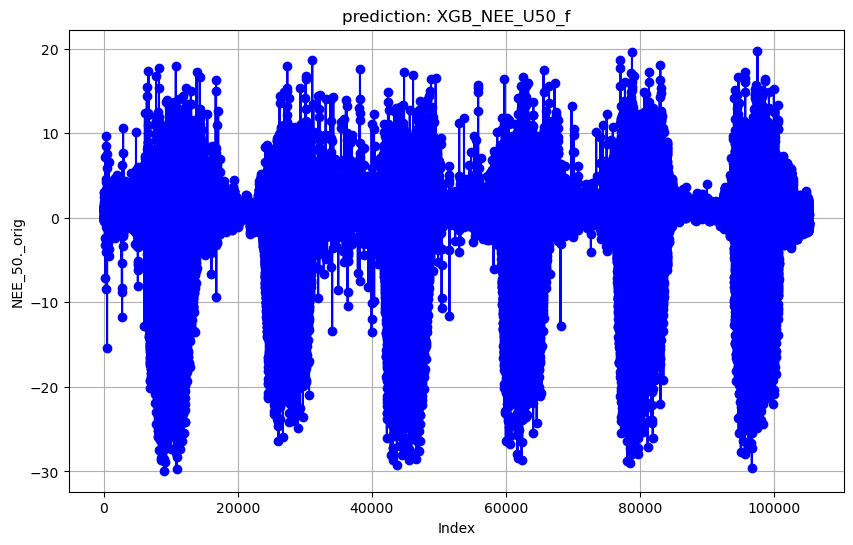

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(site_data[y_col].values, marker='o', linestyle='-', color='b')
plt.title(f'raw data: {y_col}')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(site_data["XGB_NEE_U50_f"].values, marker='o', linestyle='-', color='b')
plt.title('prediction: XGB_NEE_U50_f')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()

# Step 3: Learning curves

E:\13 Gapfill_since_2017\BART_AmeriFlux\data_train_test
03_GCC+Base
E:\13 Gapfill_since_2017\BART_AmeriFlux\XGB_models\03_GCC+Base\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9983422819350287, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.020446024638744845,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1780, n_jobs=50, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
[0]	validation_0-rmse:8.28652	validation_1-rmse:8.38299
[1]	validation_0-rmse:8.14040	vali

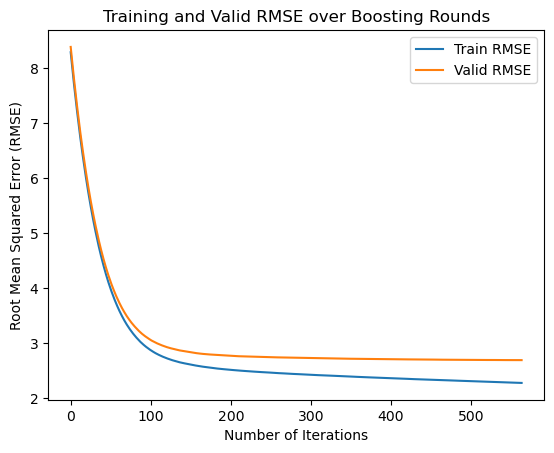

[0]	validation_0-rmse:8.31651	validation_1-rmse:8.10659
[1]	validation_0-rmse:8.16947	validation_1-rmse:7.96291
[2]	validation_0-rmse:8.02514	validation_1-rmse:7.82276
[3]	validation_0-rmse:7.88407	validation_1-rmse:7.68617
[4]	validation_0-rmse:7.74918	validation_1-rmse:7.55374
[5]	validation_0-rmse:7.61738	validation_1-rmse:7.42593
[6]	validation_0-rmse:7.48618	validation_1-rmse:7.29823
[7]	validation_0-rmse:7.35971	validation_1-rmse:7.17557
[8]	validation_0-rmse:7.23411	validation_1-rmse:7.05343
[9]	validation_0-rmse:7.11159	validation_1-rmse:6.93450
[10]	validation_0-rmse:6.99180	validation_1-rmse:6.81801
[11]	validation_0-rmse:6.87510	validation_1-rmse:6.70503
[12]	validation_0-rmse:6.76075	validation_1-rmse:6.59392
[13]	validation_0-rmse:6.64976	validation_1-rmse:6.48638
[14]	validation_0-rmse:6.54210	validation_1-rmse:6.38121
[15]	validation_0-rmse:6.43619	validation_1-rmse:6.27790
[16]	validation_0-rmse:6.33357	validation_1-rmse:6.17882
[17]	validation_0-rmse:6.23210	validation

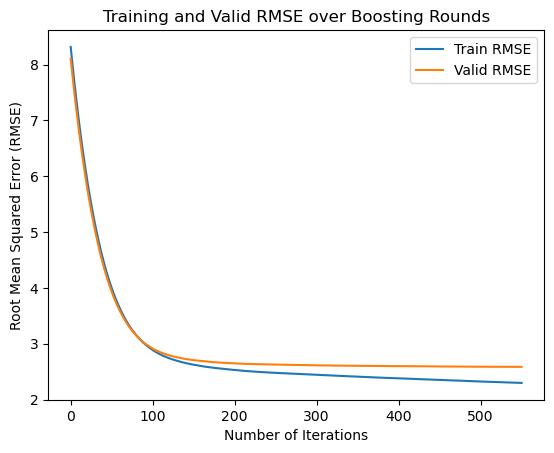

[0]	validation_0-rmse:8.27908	validation_1-rmse:8.44487
[1]	validation_0-rmse:8.13342	validation_1-rmse:8.29540
[2]	validation_0-rmse:7.99028	validation_1-rmse:8.14891
[3]	validation_0-rmse:7.85013	validation_1-rmse:8.00481
[4]	validation_0-rmse:7.71596	validation_1-rmse:7.86741
[5]	validation_0-rmse:7.58453	validation_1-rmse:7.73388
[6]	validation_0-rmse:7.45405	validation_1-rmse:7.60040
[7]	validation_0-rmse:7.32850	validation_1-rmse:7.47299
[8]	validation_0-rmse:7.20364	validation_1-rmse:7.34505
[9]	validation_0-rmse:7.08222	validation_1-rmse:7.22089
[10]	validation_0-rmse:6.96302	validation_1-rmse:7.09828
[11]	validation_0-rmse:6.84691	validation_1-rmse:6.97953
[12]	validation_0-rmse:6.73314	validation_1-rmse:6.86396
[13]	validation_0-rmse:6.62404	validation_1-rmse:6.75170
[14]	validation_0-rmse:6.51680	validation_1-rmse:6.64135
[15]	validation_0-rmse:6.41047	validation_1-rmse:6.53189
[16]	validation_0-rmse:6.30865	validation_1-rmse:6.42738
[17]	validation_0-rmse:6.20784	validation

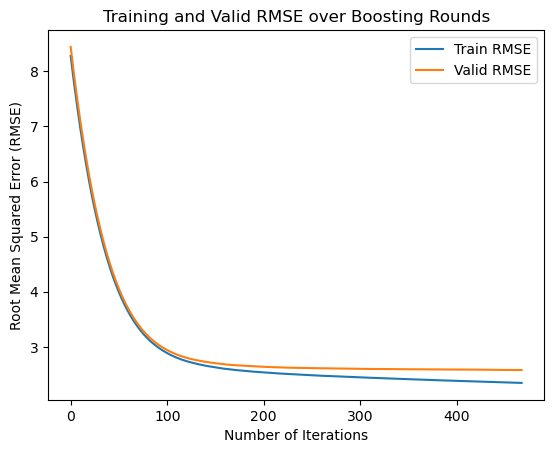

[0]	validation_0-rmse:8.30026	validation_1-rmse:8.25779
[1]	validation_0-rmse:8.15353	validation_1-rmse:8.11166
[2]	validation_0-rmse:8.00967	validation_1-rmse:7.96837
[3]	validation_0-rmse:7.86877	validation_1-rmse:7.82772
[4]	validation_0-rmse:7.73429	validation_1-rmse:7.69425
[5]	validation_0-rmse:7.60223	validation_1-rmse:7.56212
[6]	validation_0-rmse:7.47095	validation_1-rmse:7.43143
[7]	validation_0-rmse:7.34515	validation_1-rmse:7.30624
[8]	validation_0-rmse:7.21988	validation_1-rmse:7.18119
[9]	validation_0-rmse:7.09822	validation_1-rmse:7.05990
[10]	validation_0-rmse:6.97878	validation_1-rmse:6.94095
[11]	validation_0-rmse:6.86180	validation_1-rmse:6.82448
[12]	validation_0-rmse:6.74780	validation_1-rmse:6.71102
[13]	validation_0-rmse:6.63821	validation_1-rmse:6.60247
[14]	validation_0-rmse:6.53104	validation_1-rmse:6.49678
[15]	validation_0-rmse:6.42553	validation_1-rmse:6.39188
[16]	validation_0-rmse:6.32320	validation_1-rmse:6.29017
[17]	validation_0-rmse:6.22253	validation

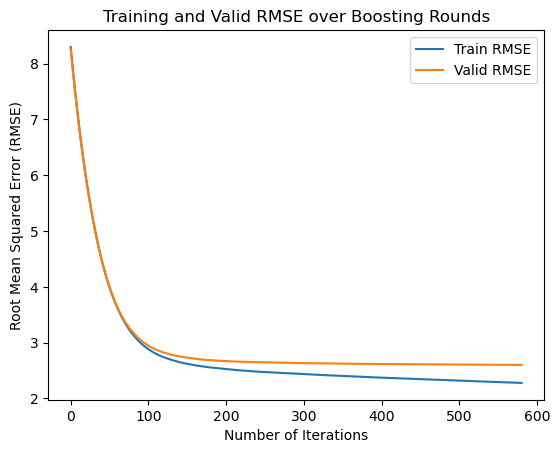

[0]	validation_0-rmse:8.30787	validation_1-rmse:8.18989
[1]	validation_0-rmse:8.16122	validation_1-rmse:8.04620
[2]	validation_0-rmse:8.01790	validation_1-rmse:7.90587
[3]	validation_0-rmse:7.87754	validation_1-rmse:7.76912
[4]	validation_0-rmse:7.74271	validation_1-rmse:7.63721
[5]	validation_0-rmse:7.61064	validation_1-rmse:7.50657
[6]	validation_0-rmse:7.47934	validation_1-rmse:7.37824
[7]	validation_0-rmse:7.35323	validation_1-rmse:7.25404
[8]	validation_0-rmse:7.22803	validation_1-rmse:7.13182
[9]	validation_0-rmse:7.10606	validation_1-rmse:7.01311
[10]	validation_0-rmse:6.98622	validation_1-rmse:6.89637
[11]	validation_0-rmse:6.86855	validation_1-rmse:6.78149
[12]	validation_0-rmse:6.75429	validation_1-rmse:6.66944
[13]	validation_0-rmse:6.64388	validation_1-rmse:6.56195
[14]	validation_0-rmse:6.53646	validation_1-rmse:6.45764
[15]	validation_0-rmse:6.42963	validation_1-rmse:6.35300
[16]	validation_0-rmse:6.32721	validation_1-rmse:6.25405
[17]	validation_0-rmse:6.22621	validation

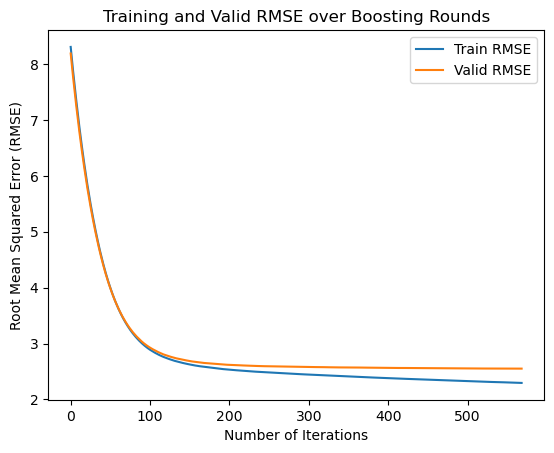

[0]	validation_0-rmse:8.30216	validation_1-rmse:8.24233
[1]	validation_0-rmse:8.15510	validation_1-rmse:8.09777
[2]	validation_0-rmse:8.01096	validation_1-rmse:7.95498
[3]	validation_0-rmse:7.87008	validation_1-rmse:7.81579
[4]	validation_0-rmse:7.73502	validation_1-rmse:7.68235
[5]	validation_0-rmse:7.60330	validation_1-rmse:7.55309
[6]	validation_0-rmse:7.47205	validation_1-rmse:7.42358
[7]	validation_0-rmse:7.34609	validation_1-rmse:7.29935
[8]	validation_0-rmse:7.22095	validation_1-rmse:7.17627
[9]	validation_0-rmse:7.09799	validation_1-rmse:7.05501
[10]	validation_0-rmse:6.97843	validation_1-rmse:6.93742
[11]	validation_0-rmse:6.86192	validation_1-rmse:6.82252
[12]	validation_0-rmse:6.74791	validation_1-rmse:6.71071
[13]	validation_0-rmse:6.63756	validation_1-rmse:6.60267
[14]	validation_0-rmse:6.53012	validation_1-rmse:6.49761
[15]	validation_0-rmse:6.42421	validation_1-rmse:6.39273
[16]	validation_0-rmse:6.32122	validation_1-rmse:6.29252
[17]	validation_0-rmse:6.21965	validation

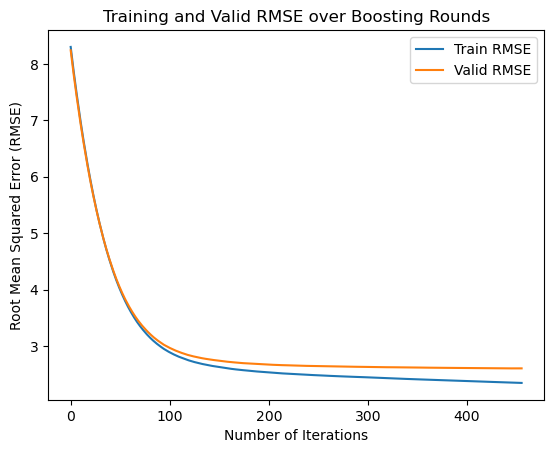

[0]	validation_0-rmse:8.29244	validation_1-rmse:8.32867
[1]	validation_0-rmse:8.14624	validation_1-rmse:8.18371
[2]	validation_0-rmse:8.00236	validation_1-rmse:8.04101
[3]	validation_0-rmse:7.86234	validation_1-rmse:7.90122
[4]	validation_0-rmse:7.72755	validation_1-rmse:7.76772
[5]	validation_0-rmse:7.59631	validation_1-rmse:7.63757
[6]	validation_0-rmse:7.46582	validation_1-rmse:7.50706
[7]	validation_0-rmse:7.33990	validation_1-rmse:7.38176
[8]	validation_0-rmse:7.21504	validation_1-rmse:7.25753
[9]	validation_0-rmse:7.09323	validation_1-rmse:7.13685
[10]	validation_0-rmse:6.97411	validation_1-rmse:7.01931
[11]	validation_0-rmse:6.85751	validation_1-rmse:6.90369
[12]	validation_0-rmse:6.74367	validation_1-rmse:6.79091
[13]	validation_0-rmse:6.63372	validation_1-rmse:6.68195
[14]	validation_0-rmse:6.52648	validation_1-rmse:6.57527
[15]	validation_0-rmse:6.42043	validation_1-rmse:6.47019
[16]	validation_0-rmse:6.31857	validation_1-rmse:6.36945
[17]	validation_0-rmse:6.21725	validation

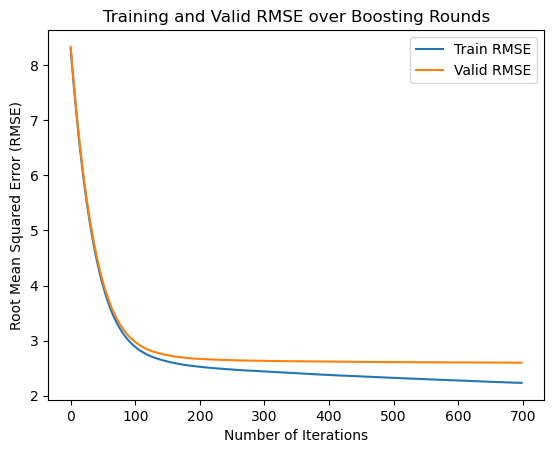

[0]	validation_0-rmse:8.27747	validation_1-rmse:8.45813
[1]	validation_0-rmse:8.13143	validation_1-rmse:8.30759
[2]	validation_0-rmse:7.98798	validation_1-rmse:8.16072
[3]	validation_0-rmse:7.84770	validation_1-rmse:8.01693
[4]	validation_0-rmse:7.71345	validation_1-rmse:7.87896
[5]	validation_0-rmse:7.58176	validation_1-rmse:7.74424
[6]	validation_0-rmse:7.45112	validation_1-rmse:7.61003
[7]	validation_0-rmse:7.32614	validation_1-rmse:7.48234
[8]	validation_0-rmse:7.20140	validation_1-rmse:7.35402
[9]	validation_0-rmse:7.07975	validation_1-rmse:7.22959
[10]	validation_0-rmse:6.96086	validation_1-rmse:7.10713
[11]	validation_0-rmse:6.84435	validation_1-rmse:6.98744
[12]	validation_0-rmse:6.73061	validation_1-rmse:6.87026
[13]	validation_0-rmse:6.62145	validation_1-rmse:6.75785
[14]	validation_0-rmse:6.51416	validation_1-rmse:6.64748
[15]	validation_0-rmse:6.40843	validation_1-rmse:6.53913
[16]	validation_0-rmse:6.30661	validation_1-rmse:6.43358
[17]	validation_0-rmse:6.20570	validation

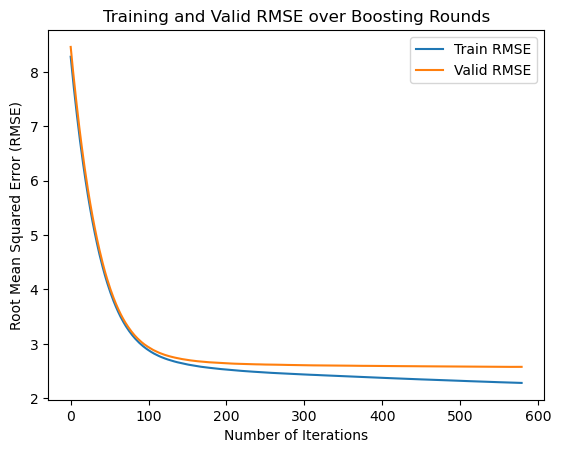

[0]	validation_0-rmse:8.32941	validation_1-rmse:7.97840
[1]	validation_0-rmse:8.18234	validation_1-rmse:7.83630
[2]	validation_0-rmse:8.03830	validation_1-rmse:7.69756
[3]	validation_0-rmse:7.89704	validation_1-rmse:7.56081
[4]	validation_0-rmse:7.76208	validation_1-rmse:7.43082
[5]	validation_0-rmse:7.62979	validation_1-rmse:7.30167
[6]	validation_0-rmse:7.49768	validation_1-rmse:7.17444
[7]	validation_0-rmse:7.37115	validation_1-rmse:7.05153
[8]	validation_0-rmse:7.24512	validation_1-rmse:6.93006
[9]	validation_0-rmse:7.12239	validation_1-rmse:6.81201
[10]	validation_0-rmse:7.00275	validation_1-rmse:6.69732
[11]	validation_0-rmse:6.88556	validation_1-rmse:6.58435
[12]	validation_0-rmse:6.77127	validation_1-rmse:6.47380
[13]	validation_0-rmse:6.66056	validation_1-rmse:6.36668
[14]	validation_0-rmse:6.55308	validation_1-rmse:6.26297
[15]	validation_0-rmse:6.44590	validation_1-rmse:6.15997
[16]	validation_0-rmse:6.34358	validation_1-rmse:6.06115
[17]	validation_0-rmse:6.24174	validation

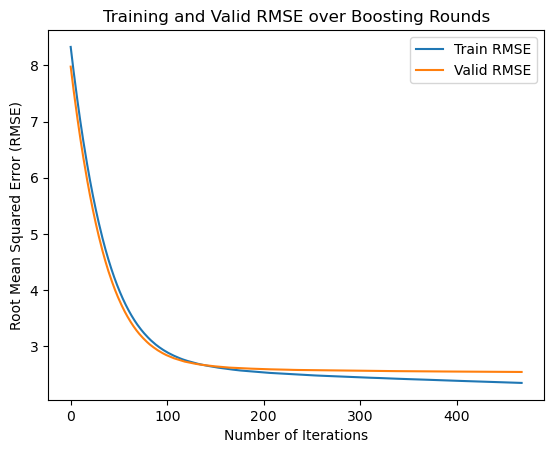

[0]	validation_0-rmse:8.26651	validation_1-rmse:8.55789
[1]	validation_0-rmse:8.12008	validation_1-rmse:8.40842
[2]	validation_0-rmse:7.97681	validation_1-rmse:8.26249
[3]	validation_0-rmse:7.83680	validation_1-rmse:8.11930
[4]	validation_0-rmse:7.70261	validation_1-rmse:7.98360
[5]	validation_0-rmse:7.57228	validation_1-rmse:7.85121
[6]	validation_0-rmse:7.44147	validation_1-rmse:7.71816
[7]	validation_0-rmse:7.31606	validation_1-rmse:7.59045
[8]	validation_0-rmse:7.19128	validation_1-rmse:7.46327
[9]	validation_0-rmse:7.06914	validation_1-rmse:7.33872
[10]	validation_0-rmse:6.95009	validation_1-rmse:7.21750
[11]	validation_0-rmse:6.83376	validation_1-rmse:7.09969
[12]	validation_0-rmse:6.71990	validation_1-rmse:6.98398
[13]	validation_0-rmse:6.61040	validation_1-rmse:6.87265
[14]	validation_0-rmse:6.50351	validation_1-rmse:6.76407
[15]	validation_0-rmse:6.39785	validation_1-rmse:6.65637
[16]	validation_0-rmse:6.29600	validation_1-rmse:6.55310
[17]	validation_0-rmse:6.19490	validation

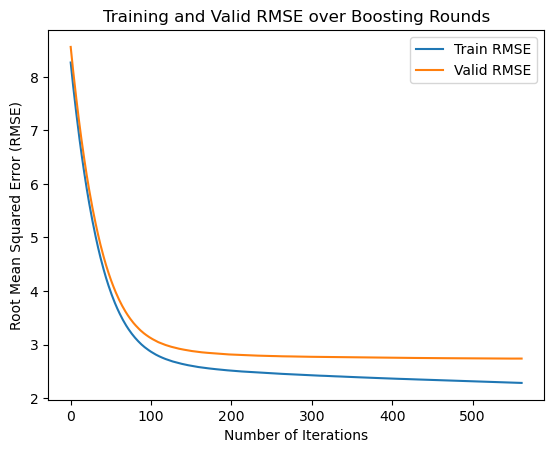

In [11]:
# from sklearn.model_selection import train_test_split
print(data_train_test_dir)
for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir / subset_name) / "model.pkl"
    print(model_path)

    with open(model_path, 'rb') as f:
        reg = pkl.load(f)
    print(reg)

    # 10 fold model evaluation
    for i in range(1,11):
        train = pd.read_csv(data_train_test_dir / f"train{i}.csv", index_col=0).dropna(subset=[y_col])
        test = pd.read_csv(data_train_test_dir / f"test{i}.csv", index_col=0).dropna(subset=[y_col])
        train = add_time_vars(train)
        X_train = train[subset_features]
        y_train = train[y_col]
        test = add_time_vars(test)
        X_test = test[subset_features]
        y_test = test[y_col]
        
        # X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)
        results = reg.evals_result()
        plt.plot(results['validation_0']['rmse'], label='Train RMSE')
        plt.plot(results['validation_1']['rmse'], label='Valid RMSE')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Root Mean Squared Error (RMSE)')
        plt.legend()
        plt.title('Training and Valid RMSE over Boosting Rounds')
        plt.savefig(learning_curve_dir / (subset_name + f'_learning_curve{i}.png'))
        plt.show()
        
        # test performance
        y_test_pred = reg.predict(X_test)
        scores = compute_performance_metrics(y_test, y_test_pred)
        scores_df = pd.DataFrame(scores, index=[0])
        scores_df.to_csv(test_performance_dir / (subset_name + f"_test_performance{i}.csv"), index=False)

        # test prediction
        test['XGB_NEE_U50_fall'] = y_test_pred
        test['XGB_NEE_U50_f'] = np.where(test[y_col].notnull(), test[y_col], test['XGB_NEE_U50_fall'])
        test.to_csv(test_prediction_dir / (subset_name + f"_test_prediction{i}.csv"), index=False)


# Step 4: Feature importance

['TIMESTAMP_END', 'gcc', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos']
03_GCC+Base
E:\13 Gapfill\gapfill_NEE_50_best_hyperparameter\AmeriFlux_2017-2022\XGB_models\03_GCC+Base\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9983422819350287, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.020446024638744845,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1780, n_jobs=50, num_parallel_tree=None,
             predictor=None, random_state=42, ...)


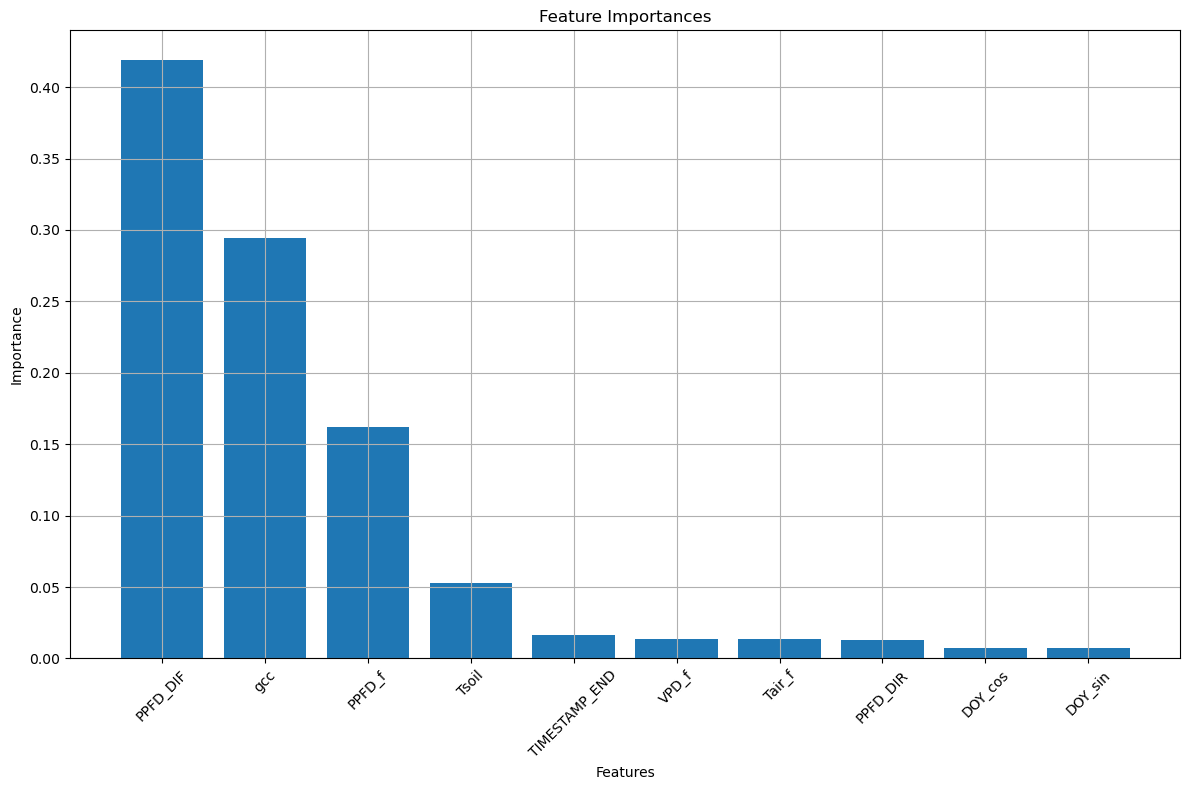

<Figure size 640x480 with 0 Axes>

In [ ]:
print(subset_features )
for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir / subset_name) / "model.pkl"
    print(model_path)

    with open(model_path, 'rb') as f:
        reg = pickle.load(f)
    print(reg)

import pickle as pickle
y_col = 'NEE_U50_orig'
feature_importance_df = pd.DataFrame()
import pickle   
model_path = (save_dir / subset_name) / "model.pkl"  
with open(model_path, 'rb') as f:
    reg = pickle.load(f)

X = site_data_no_na[subset_features]
y = site_data_no_na[y_col] 
reg.fit(X, y)
feature_importance_df['Feature_Importances'] = reg.feature_importances_
feature_importance_df['subset_features'] = subset_features
# Sort by feature importances
feature_importance_df = feature_importance_df.sort_values(by='Feature_Importances', ascending=False)
feature_importance_df
feature_importance_df.to_csv(site_data_dir / "output_feature_importances_gcc_subset.csv", index=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['subset_features'], feature_importance_df['Feature_Importances'])
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(site_data_dir, 'output_feature_importances_gcc_subset.png'))

# Step 5: Model performance on test set

In [13]:
print(test_performance_dir)
# for GCC + Base as predictors
csv_files = [
    os.path.join(test_performance_dir, file) 
    for file in os.listdir(test_performance_dir) 
    if file.startswith('03') and file.endswith('.csv')
]
csv_list = [pd.read_csv(file) for file in csv_files]
csv_dict = {os.path.basename(file): pd.read_csv(file) for file in csv_files}
combined_data = pd.concat(csv_list, ignore_index=True)
combined_data

E:\13 Gapfill_since_2017\BART_AmeriFlux\XGB_test_performance


,mse,mae,nmae,r2,pr2,bias
0,7.258853,1.729670,0.228185,0.873668,0.873894,-0.045151
1,6.683077,1.682201,0.228462,0.876732,0.876769,0.006984
2,6.650166,1.687355,0.221822,0.885072,0.885126,-0.031948
3,6.762047,1.707351,0.227979,0.879434,0.879439,-0.015511
4,6.508852,1.685369,0.227264,0.881648,0.881653,-0.014924
5,6.765594,1.703060,0.227510,0.879261,0.879310,0.002803
6,6.754196,1.707005,0.226875,0.880690,0.880854,0.088919
7,6.642176,1.689055,0.223065,0.884153,0.884173,0.016499
8,6.453525,1.682773,0.231010,0.878379,0.878481,-0.031775
9,7.493643,1.758840,0.228733,0.873264,0.873343,-0.017163


model performance on test set
RMSE is 2.61 ± 0.06
R2 is 0.879 ± 0.004
Bias is -0.0041 ± 0.0359


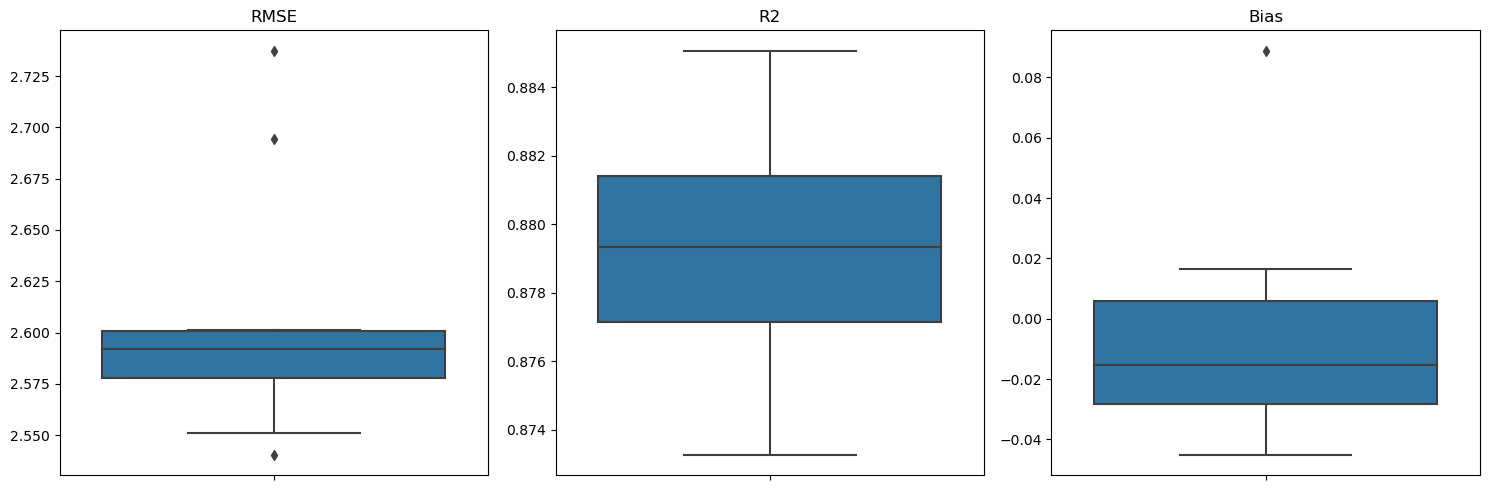

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the mean and standard deviation for RMSE
rmse_mean = np.mean(np.sqrt(combined_data['mse']))
rmse_sd = np.std(np.sqrt(combined_data['mse']))

# Calculate the mean and standard deviation for R2
r2_mean = np.mean(combined_data['r2'])
r2_sd = np.std(combined_data['r2'])

# Calculate the mean and standard deviation for Bias
bias_mean = np.mean(combined_data['bias'])
bias_sd = np.std(combined_data['bias'])

# Print the results
print("model performance on test set")
print(f"RMSE is {rmse_mean:.2f} ± {rmse_sd:.2f}")
print(f"R2 is {r2_mean:.3f} ± {r2_sd:.3f}")
print(f"Bias is {bias_mean:.4f} ± {bias_sd:.4f}")

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE Boxplot
sns.boxplot(y=np.sqrt(combined_data['mse']), ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', rotation=0)

# R2 Boxplot
sns.boxplot(y=combined_data['r2'], ax=axes[1])
axes[1].set_title('R2')
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', rotation=0)

# Bias Boxplot
sns.boxplot(y=combined_data['bias'], ax=axes[2])
axes[2].set_title('Bias')
axes[2].set_ylabel('')
axes[2].tick_params(axis='y', rotation=0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(test_performance_dir, "test_performance_using_GCC"))

# Step 6: Annual sums

In [17]:
def agg_by_year(data, data_var_name, start_year, end_year):
    
    import pandas as pd
    # Initialize an empty dataframe to store aggregated data
    agg_data = pd.DataFrame()

    # Define molar mass of CO2 in g/mol
    molar_mass = 12.011

    # Define a function to get the number of days in a year
    def get_days_in_year(year):
        import calendar
        return 366 if calendar.isleap(year) else 365

    # Iterate over years from start_year to end_year
    for i in range(start_year, end_year + 1):
        # Subset data for the current year
        data_sub = data[data['Year'] == i]
        
        # Extract data variable
        half_hour = data_sub[data_var_name]
        
        # Calculate mean CO2 value
        agg_co2 = half_hour.mean(skipna=True)
        
        # Calculate aggregated value
        agg = agg_co2 * 1e-6 * molar_mass * 3600 * 24 * get_days_in_year(i)
        
        # Append to agg_data dataframe
        agg_data = agg_data.append(pd.DataFrame({'Year': [i], 'annual_sum': [agg]}), ignore_index=True)

    return agg_data

In [18]:
print(all_prediction_dir)
file_path = f"{all_prediction_dir}/03_GCC+Base_all_prediction.csv"
df = pd.read_csv(file_path)
agg_data = agg_by_year(df, "XGB_NEE_U50_f", 2017, 2022)

output_file_path = site_data_dir / "AmeriFlux_NEE_annual_sum.csv"
agg_data.to_csv(output_file_path, index=False)
agg_data

E:\13 Gapfill_since_2017\BART_AmeriFlux\XGB_accurate_prediction


,Year,annual_sum
0,2017,18.960983
1,2018,-11.703469
2,2019,-117.687979
3,2020,-11.664312
4,2021,44.138802
5,2022,-37.180210


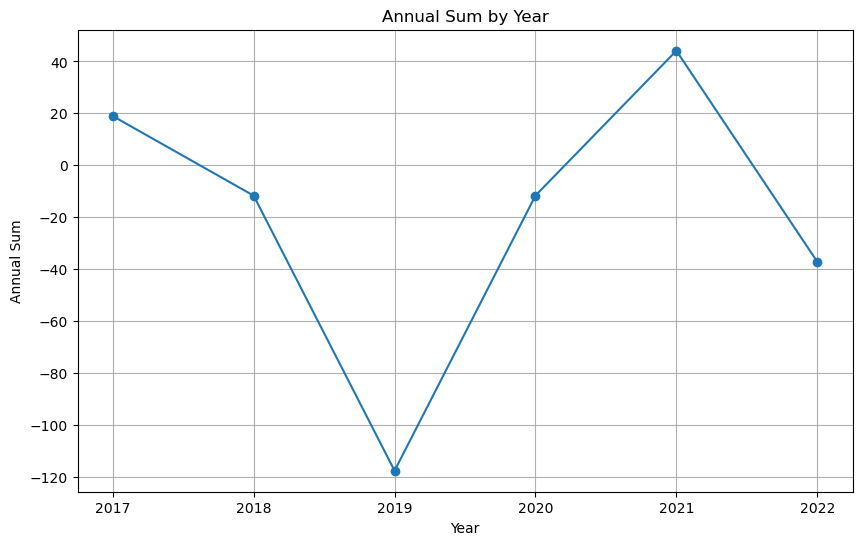

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agg_data['Year'], agg_data['annual_sum'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Annual Sum')
plt.title('Annual Sum by Year')
plt.grid(True)

plt.savefig(os.path.join(site_data_dir, "AmeriFlux_NEE_annual_sum.png"))
plt.show()

# Step 7: Monthly sum

In [20]:
def agg_by_month(df, var_name, start_year, end_year):
    print("check if you have Month and Year in input data!")
    
    import pandas as pd

    # Initialize an empty DataFrame to store monthly sums
    monthly_df = pd.DataFrame(columns=['Year', 'Month', 'monthly_sum'])
    
    # Define molar mass of CO2 in g/mol
    molar_mass = 12.011

    # Define a function to get the number of days in a month
    def get_days_in_month(year, month):
        import calendar
        return calendar.monthrange(year, month)[1]

    # Filter data for the specified range of years
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

    # Iterate over unique years in the DataFrame
    for year in range(start_year, end_year + 1):
        # Iterate over months (1 to 12)
        for month in range(1, 13):
            # Subset DataFrame for the current year and month
            df_sub = df[(df['Year'] == year) & (df['Month'] == month)]
            
            # Extract data variable
            half_hour = df_sub[var_name]
            
            # Calculate mean CO2 value
            agg_co2 = half_hour.mean(skipna=True)
            
            # Calculate aggregated value
            days_in_month = get_days_in_month(year, month)
            agg = agg_co2 * 1e-6 * molar_mass * 3600 * 24 * days_in_month
            
            # Append result to monthly_df DataFrame
            monthly_df = monthly_df.append({'Year': year, 'Month': month, 'monthly_sum': agg}, ignore_index=True)
    
    return monthly_df

In [21]:
agg_data = agg_by_month(df, "XGB_NEE_U50_f", 2017, 2022)
output_file_path = site_data_dir / "AmeriFlux_NEE_monthly_sum.csv"
agg_data.to_csv(output_file_path, index=False)
agg_data

check if you have Month and Year in input data!


,Year,Month,monthly_sum
0,2017.0,1.0,32.941389
1,2017.0,2.0,28.138876
2,2017.0,3.0,36.230758
3,2017.0,4.0,25.766337
4,2017.0,5.0,-9.733567
...,...,...,...
67,2022.0,8.0,-27.262597
68,2022.0,9.0,-7.587102
69,2022.0,10.0,48.785244
70,2022.0,11.0,24.953014


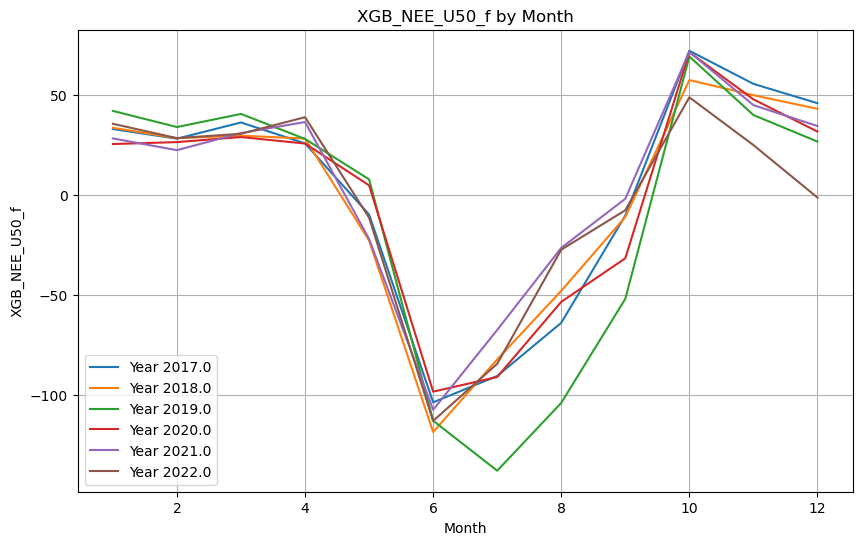

In [22]:
# Plot the results
plt.figure(figsize=(10, 6))

# Iterate over unique years in the DataFrame
for year in agg_data['Year'].unique():
    # Filter data for the current year
    year_data = agg_data[agg_data['Year'] == year]
    # Plot XGB_NEE_U50_f by Month, with different colors for each Year
    plt.plot(year_data['Month'], year_data['monthly_sum'], label=f'Year {year}')

plt.xlabel('Month')
plt.ylabel('XGB_NEE_U50_f')
plt.title('XGB_NEE_U50_f by Month')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(site_data_dir, "AmeriFlux_NEE_monthly_sum.png"))
plt.show()